In [1]:
import os
import random
from shutil import copyfile

In [2]:
print(len(os.listdir('data/source2/with_mask')))

690


In [3]:
print(len(os.listdir('data/source2/without_mask')))

686


In [4]:
try:
    base = 'data/face-mask'
    
    train_dir = os.path.join(base,'train')
    test_dir = os.path.join(base,'test')
    
    train_with_mask_dir = os.path.join(train_dir,'with_mask')
    train_without_mask_dir = os.path.join(train_dir,'without_mask')
    
    test_with_mask_dir = os.path.join(test_dir,'with_mask')
    test_without_mask_dir = os.path.join(test_dir,'without_mask')
    
    os.mkdir(base)
    
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    
    os.mkdir(train_with_mask_dir)
    os.mkdir(train_without_mask_dir)
    
    os.mkdir(test_with_mask_dir)
    os.mkdir(test_without_mask_dir)
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    list = os.listdir(SOURCE)
    all_files = []
    for f in list :
        file_path = SOURCE +'/'+ f
        if os.path.getsize(file_path):
            all_files.append(f)
        else:
            print('files not found')
            
    split_val = int(len(all_files)*SPLIT_SIZE)
    shuffled_list = random.sample(all_files,len(all_files))
    train_file = shuffled_list[:split_val]
    test_file = shuffled_list[split_val:]
    for f in train_file:
        copyfile(SOURCE+'/'+f,TRAINING+'/'+f)
    for f in test_file:
        copyfile(SOURCE+'/'+f,TESTING+'/'+f)

In [6]:

with_mask_source_dir = 'data/source2/with_mask'
with_mask_train_dir = 'data/face-mask/train/with_mask'
with_mask_test_dir = 'data/face-mask/test/with_mask'

without_mask_source_dir = 'data/source2/without_mask'
without_mask_train_dir = 'data/face-mask/train/without_mask'
without_mask_test_dir = 'data/face-mask/test/without_mask'

split_size = .8
split_data(with_mask_source_dir, with_mask_train_dir, with_mask_test_dir, split_size)
split_data(without_mask_source_dir, without_mask_train_dir, without_mask_test_dir, split_size)

In [7]:
print(len(os.listdir('data/face-mask/train/with_mask')))
print(len(os.listdir('data/face-mask/test/with_mask')))
print(len(os.listdir('data/face-mask/train/without_mask')))
print(len(os.listdir('data/face-mask/test/without_mask')))

552
138
548
138


In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [13]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [14]:
TRAINING_DIR = 'data/face-mask/train/'
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))

VALIDATION_DIR = 'data/face-mask/test/'
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [15]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.7569 - acc: 0.4955WARNING:tensorflow:From S:\Users\sifat\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-001.model\assets
110/110 [==============================] - 30s 275ms/step - loss: 0.7569 - acc: 0.4955 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 2/30
110/110 [==============================] - 29s 263ms/step - loss: 0.6947 - acc: 0.5264 - val_loss: 0.6879 - val_acc: 0.6812
Epoch 3/30
110/110 [==============================] - 29s 266ms/step - loss: 0.6201 - acc: 0.6436 - val_loss: 0.3414 - val_acc: 0.8587
Epoch 4/3

Text(0.5, 1.0, 'Training and validation loss')

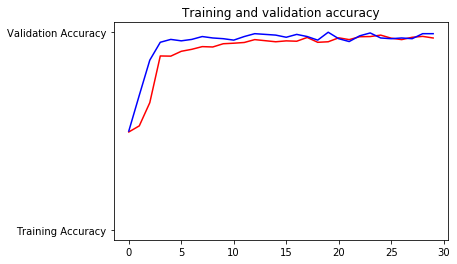

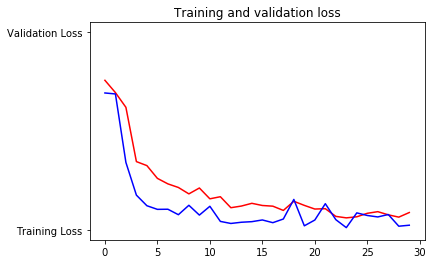

In [16]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2
path = 'data/without_mask.jpg'
img=image.load_img(path, target_size=(150, 150))
x=image.img_to_array(img)
print(x.shape)
x=np.expand_dims(x, axis=0)
print(x.shape)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)

print(classes[0])

if classes[0][0]:
    print(" is a with mask")

else:
    print(" is a without mask")

(150, 150, 3)
(1, 150, 150, 3)
[0. 1.]
 is a without mask


In [21]:
# face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [24]:
# labels_dict={0:'without_mask',1:'with_mask'}
# color_dict={0:(0,0,255),1:(0,255,0)}

# size = 4
# webcam = cv2.VideoCapture(0) #Use camera 0

# # We load the xml file
# classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# while True:
#     (rval, im) = webcam.read()
#     im=cv2.flip(im,1,1) #Flip to act as a mirror

#     # Resize the image to speed up detection
# #     mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

#     # detect MultiScale / faces 
#     faces = classifier.detectMultiScale(im)

#     # Draw rectangles around each face
#     for f in faces:
#         (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
#         #Save just the rectangle faces in SubRecFaces
#         face_img = im[y:y+h, x:x+w]
#         resized=cv2.resize(face_img,(150,150))
#         normalized=resized/255.0
#         reshaped=np.expand_dims(normalized, axis=0)
#         reshaped = np.vstack([reshaped])
#         result=model.predict(reshaped,batch_size=10)
#         #print(result)
        
#         label=np.argmax(result,axis=1)[0]
      
#         cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
#         cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
#         cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
#     # Show the image
#     cv2.imshow('LIVE',   im)
#     key = cv2.waitKey(10)
#     # if Esc key is press then break out of the loop 
#     if key == 27: #The Esc key
#         break
# # Stop video
# webcam.release()

# # Close all started windows
# cv2.destroyAllWindows()